# **Experiment: Translation-invariant MSE optimal multipliers in 1D**

This notebook reproduces the results of the numerical experiments in

> D. Castelli Lacunza and C. A. Sing Long, "*Translation-invariant extrapolation in frequency using adaptive multipliers*." January 31, 2025.

You can use the following code to cite our work.
```bibtex
@article{castelli_translation_invariant_2025, 
  title   = {Translation-invariant extrapolation in frequency using adaptive multipliers},  
  author  = {Castelli Lacunza, Diego and Sing Long, Carlos A.}, 
  date    = {2025-01-31}
}
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys

if ".." not in sys.path:
    sys.path.insert(0, "../..")

SAVE_FIGURES = False

def savefig(fname):
  if SAVE_FIGURES:
    plt.savefig(f'FIG/E01_{fname:s}.png', bbox_inches='tight', dpi=300)
    plt.savefig(f'FIG/E01_{fname:s}.eps', bbox_inches='tight')

In [2]:
# labels
label_real = 'real part'
label_imag = 'imaginary part'
# for computing Fourier integrals
M = 4096

In [3]:
from adaptiveExtrapolationInFrequency.routines.integrals import inverse_fourier_transform_1d

## Contents

1. [Signals](#signals)
2. [Low-frequency set](#low-frequency-set)
3. [Exact multipliers](#exact-multipliers)
4. [MSE optimal multiplier](#MSE-optimal-multiplier)
5. [MSE optimal multiplier with centering](#MSE-optimal-multiplier-with-centering)
6. [Translation-invariant optimal multiplier](#translation-invariant-optimal-multiplier)
7. [Comparison](#comparison)

## Signals

Consider a **trapezoid signal** and a **triangle signal**. Let $\delta \in (0, 1]$. 

The Fourier transform of the **trapezoid signal**
$$
  u(x) = \begin{cases}
    \frac{1 + x}{1-\delta}    & x \in (-1, -\delta] \\
    1                         & x \in (-\delta,\delta] \\
    \frac{1 - x}{1-\delta}    & x \in (\delta, 1]
  \end{cases}
$$
is
$$
  f(\xi) = \frac{\cos(2\pi \delta \xi) - \cos(2\pi \xi)}{2\pi^2 (1-\delta)\xi^2} = \frac{\sin((1+\delta)\pi\xi) \sin((1-\delta)\pi\xi)}{\pi^2 (1 - \delta)\xi^2} = (1+\delta)\operatorname{sinc}((1+\delta)\xi)\operatorname{sinc}(1-\delta)\xi).
$$


The Fourier transform of the **triangle signal**
$$
  u(x) = \begin{cases}
    1 + x             & x\in (-1, 0]\\
    1 - \delta^{-1}x  & x\in (0, \delta] \\
    0                 & \text{o.w.}
  \end{cases}
$$
is
$$
  f(\xi) = \frac{1 + \delta^{-1}}{4\pi^2 \xi^2} - \frac{1}{4\pi^2 \xi^2}(e^{2\pi i \xi} + \delta^{-1}e^{-2\pi i \delta \xi}).
$$

In [4]:
def trapezoid(xo, a, delta):
  def _fcn(x):
    return np.maximum(0.0, np.minimum(1.0, (1.0 - np.abs((x - xo)/a)) / (1 - delta)))
  return _fcn

def trapezoid_fourier(xo, a, delta): 
  def _fcn(w):
    return a * np.exp(-2 * np.pi * 1j * xo * w) * (1 + delta) *  np.sinc((1 + delta) * a * w) * np.sinc((1 - delta) * a * w)
  return _fcn

def triangle(xo, a, delta):
  def _fcn(x):
    return np.where(x <= xo, np.maximum(0.0, 1.0 + (x - xo)/a), np.maximum(0.0, 1.0 - (x - xo) / (a * delta)))
  return _fcn

def triangle_fourier(xo, a, delta):
  def _fcn(w):
    return np.where(w != 0, a * np.exp(-2 * np.pi * 1j * xo * w) * (1 + 1/delta - np.exp(2 * np.pi * 1j * a * w) - np.exp(-2 * np.pi * 1j * delta * a * w) / delta) / np.maximum(1E-16, (2 * np.pi * a * w) ** 2), 0.5*a*(1+delta))
  return _fcn

In [5]:
# trapezoid is signal a
# - parameter
delta_a = 0.70
# - scaling
scale_a = 0.7
# - translation
co_a = -0.3
# - handles
u_a = trapezoid(co_a, scale_a, delta_a)
f_a = trapezoid_fourier(co_a, scale_a, delta_a)

print(f'Function 1')
print(f' - Parameter      : {delta_a:+.3f}')
print(f' - Scaling        : {scale_a:+.3f}')
print(f' - Translation    : {co_a:+.3f}')

# triangle is signal b
# - auxiliary parameters
n = 4.0
a = 0.32
# - parameter
delta_b = 1/n
# - scaling
scale_b = n * a
# - translation
co_b =  n - np.sqrt(n * (n + 1) / 2) - 0.1
# - handles
u_b = triangle(co_b, scale_b, delta_b)
f_b = triangle_fourier(co_b, scale_b, delta_b)

print(f'Function 2')
print(f' - Parameter      : {delta_b:+.3f}')
print(f' - Scaling        : {scale_b:+.3f}')
print(f' - Translation    : {co_b:+.3f}')

Function 1
 - Parameter      : +0.700
 - Scaling        : +0.700
 - Translation    : -0.300
Function 2
 - Parameter      : +0.250
 - Scaling        : +1.280
 - Translation    : +0.738


Plot in the spatial and frequency domains.

In [6]:
# spatial range
num_x = 2048
x_max = 2
x = np.linspace(-x_max, +x_max, num_x)
# frequency range
num_w = 2048
w_max = 5
w = np.linspace(-w_max, +w_max, num_w)

In [7]:
def plot_fourier_pair(f_w, u_x, 
                      title_f = None, fov_w = None, lim_u = [ -0.15, +1.25 ], ticks_u = [ 0, 1 ],
                      title_u = None, fov_x = None, lim_f = [ -1.25, +1.25 ], ticks_f = [ -1, 0, +1 ]):
  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  plt.plot(w, f_w.real, color='b', label=label_real)
  plt.plot(w, f_w.imag, color='r', label=label_imag)
  plt.xlim([ w.min(), w.max() ])
  plt.ylim(lim_f)
  if fov_w:
    plt.xticks(fov_w)
  else:
    plt.xticks([ w.min(), 0, w.max() ])
  plt.yticks(ticks_f)
  plt.xlabel('$\\xi$', fontsize=14)
  plt.legend(fontsize=12, loc='upper right')
  plt.title(title_f)
  plt.subplot(1, 2, 2)
  plt.plot(x, u_x.real, color='b', label=label_real)
  plt.plot(x, u_x.imag, color='r', label=label_imag)
  plt.xlim([ x.min(), x.max() ])
  plt.ylim(lim_u)
  if fov_x:
    plt.xticks(fov_x)
  else:
    plt.xticks([ x.min(), 0, x.max() ])
  plt.yticks(ticks_u)
  plt.xlabel('$x$', fontsize=14)
  plt.legend(fontsize=12, loc='upper right')
  plt.title(title_u)
  plt.show()

Plot Fourier transform pairs.

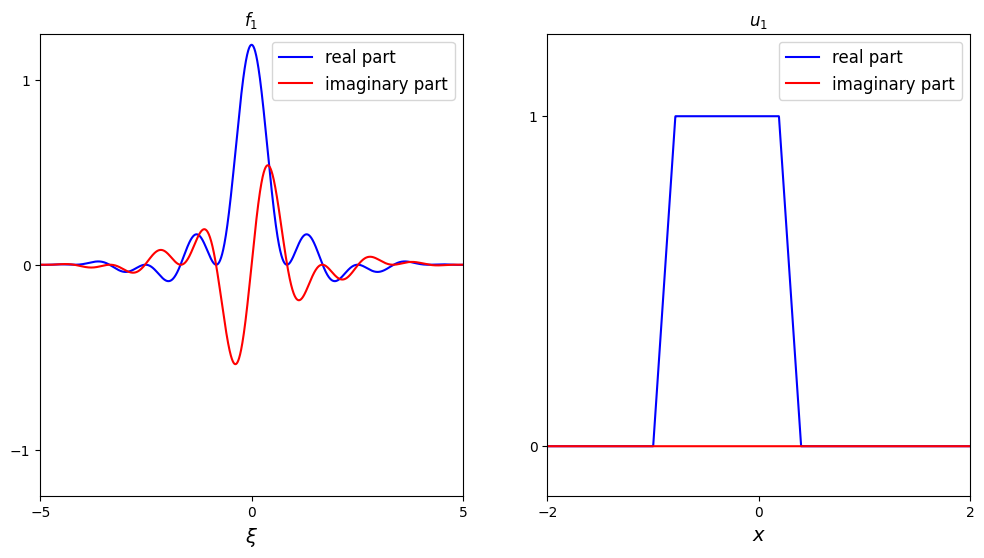

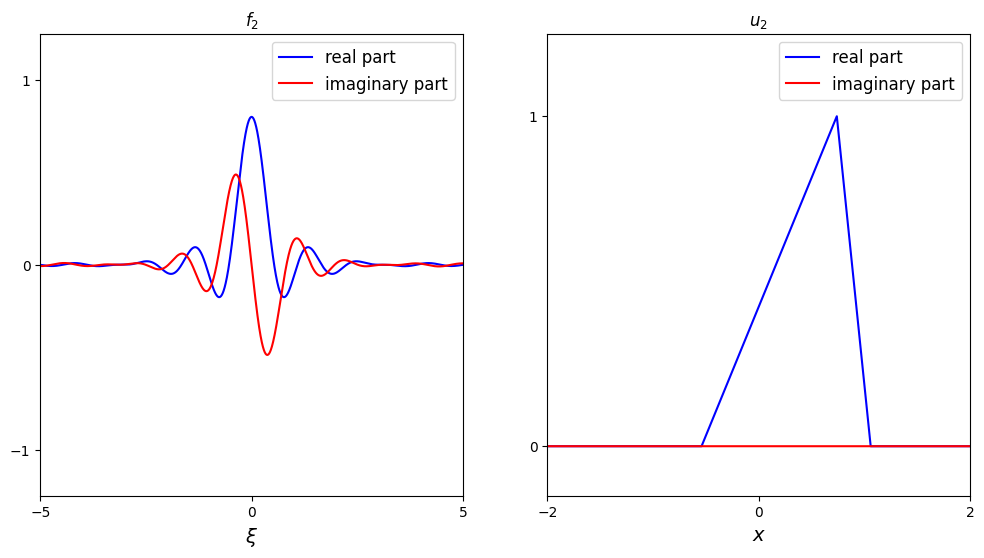

In [8]:
# trapezoid
plot_fourier_pair(f_a(w), u_a(x), title_f=f'$f_1$', title_u=f'$u_1$')
# triangle
plot_fourier_pair(f_b(w), u_b(x), title_f=f'$f_2$', title_u=f'$u_2$')

In [9]:
# figures for paper ------------------------------------------------------------------------------------------
# --- frequency domain
plt.figure(figsize=(8, 8))
plt.plot(w, f_a(w).real, color='b', label='Re($f_1$)')
plt.plot(w, f_a(w).imag, color='r', label='Im($f_1$)')
plt.xlim([ w.min(), w.max() ])
plt.ylim([ -1.25, +1.25 ])
plt.xticks([ w.min(), 0, w.max() ])
plt.yticks([ -1.0, 0.0, +1.0 ])
plt.xlabel('$\\xi$', fontsize=14)
plt.legend(fontsize=12, loc='upper right')

savefig('SIGNAL_A_FREQUENCY')

plt.close()

plt.figure(figsize=(8, 8))
plt.plot(w, f_b(w).real, color='b', label='Re($f_2$)')
plt.plot(w, f_b(w).imag, color='r', label='Im($f_2$)')
plt.xlim([ w.min(), w.max() ])
plt.ylim([ -1.25, +1.25 ])
plt.xticks([ w.min(), 0, w.max() ])
plt.yticks([ -1.0, 0.0, +1.0 ])
plt.xlabel('$\\xi$', fontsize=14)
plt.legend(fontsize=12, loc='upper right')

savefig('SIGNAL_B_FREQUENCY')

plt.close()

# --- spatial domain
plt.figure(figsize=(8, 8))
plt.plot(x, u_a(x), color='b', label='$u_1$', linewidth=3)
plt.plot(x, u_b(x), color='r', label='$u_2$', linewidth=3)
plt.xlim([ x.min(), x.max() ])
plt.ylim([ -0.15, +1.25 ])
plt.xticks([ x.min(), 0, x.max() ], fontsize=22)
plt.yticks([ 0.0, +1.0 ], fontsize=22)
plt.xlabel('$x$', fontsize=24)
plt.legend(fontsize=24, loc='upper right')

savefig('SIGNALS_SPACE')

plt.close()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


## Low-frequency set

The low-frequency set is $\Omega_0 = [-\xi_{\max}, +\xi_{\max}]$ and the extrapolation factor is $\alpha$. Therefore, the goal is to extrapolate to the interval $\alpha\Omega_0 = [-\alpha \xi_{\max}, +\alpha \xi_{\max}]$. In this case
$$
  \Omega = \alpha \Omega_0\setminus \Omega_0 = [-\alpha \xi_{\max}, -\xi_{\max}]\cup [+\xi_{\max}, +\alpha \xi_{\max}].
$$

In [10]:
from adaptiveExtrapolationInFrequency.objects.domain import Square1D, Annulus1D

In [11]:
# extrapolation factor
alpha = 6.0
# maximum frequency
xi_max = 1.5

We use our specific implementation of these domains.

In [12]:
# low-frequency set
D_lo = Square1D(width = 2 * xi_max)
# high-frequency set
D_hi = Square1D(width = 2 * alpha * xi_max)
# extrapolation
D_ex = Annulus1D(rmin = xi_max, rmax = alpha * xi_max)
# domain
DS = Square1D(width = 2 * xi_max)

For plotting in the spatial and frequency domains.

In [13]:
# frequency range
num_w = 2048
w_max = 4
w = np.linspace(-w_max, +w_max, num_w)
# spatial range
num_x = 4096
x_max = 3
x = np.linspace(-x_max, +x_max, num_x)

In [14]:
def plot_approximations(u_lo_x, u_hi_x, u_ex_x, 
                        title_lo='low-frequency approximation', title_hi='high-frequency approximation', title_ex=None):
  plt.figure(figsize=(16, 12))
  plt.subplot(2, 3, 1)
  plt.plot(x, u_lo_x.real, color='b', label=label_real)
  plt.plot(x, u_lo_x.imag, color='r', label=label_imag)
  plt.xlim([ x.min(), x.max() ])
  plt.ylim([ -0.15, +1.25 ])
  plt.xticks([ x.min(), 0.0, x.max() ])
  plt.yticks([ 0.0, 1.0 ])
  plt.xlabel('$x$', fontsize=14)
  plt.legend(fontsize=12, loc='upper right')
  plt.title(title_lo)
  plt.subplot(2, 3, 2)
  plt.plot(x, u_hi_x.real, color='b', label=label_real)
  plt.plot(x, u_hi_x.imag, color='r', label=label_imag)
  plt.xlim([ x.min(), x.max() ])
  plt.ylim([ -0.15, +1.25 ])
  plt.xticks([ x.min(), 0.0, x.max() ])
  plt.yticks([ 0.0, 1.0 ])
  plt.xlabel('$x$', fontsize=14)
  plt.legend(fontsize=12, loc='upper right')
  plt.title(title_hi)
  plt.subplot(2, 3, 3)
  plt.plot(x, u_ex_x.real, color='b', label=label_real)
  plt.plot(x, u_ex_x.imag, color='r', label=label_imag)
  plt.xlim([ x.min(), x.max() ])
  plt.ylim([ -0.15, +1.25 ])
  plt.xticks([ x.min(), 0.0, x.max() ])
  plt.yticks([ 0.0, 1.0 ])
  plt.xlabel('$x$', fontsize=14)
  plt.legend(fontsize=12, loc='upper right')
  plt.title(title_ex)
  plt.show()

Plot the approximation of the signals from their low-frequency content $f_k|_{\Omega_0}$ and from their perfectly extrapolated frequency content $f_k|_{\alpha\Omega_0}$.

In [15]:
# low-frequency approximation
ua_lo_x = inverse_fourier_transform_1d(lambda w : D_lo.eval_window(w) * f_a(w), x, xi_max, M)
ub_lo_x = inverse_fourier_transform_1d(lambda w : D_lo.eval_window(w) * f_b(w), x, xi_max, M)
# high-frequency approximation
ua_hi_x = inverse_fourier_transform_1d(lambda w : D_hi.eval_window(w) * f_a(w), x, alpha * xi_max, M)
ub_hi_x = inverse_fourier_transform_1d(lambda w : D_hi.eval_window(w) * f_b(w), x, alpha * xi_max, M)

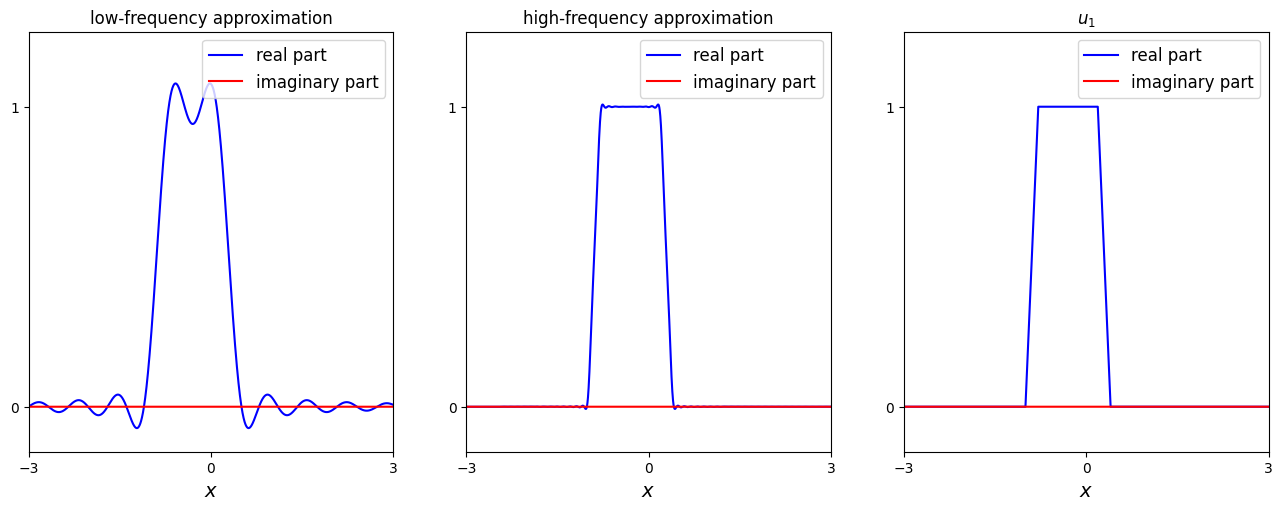

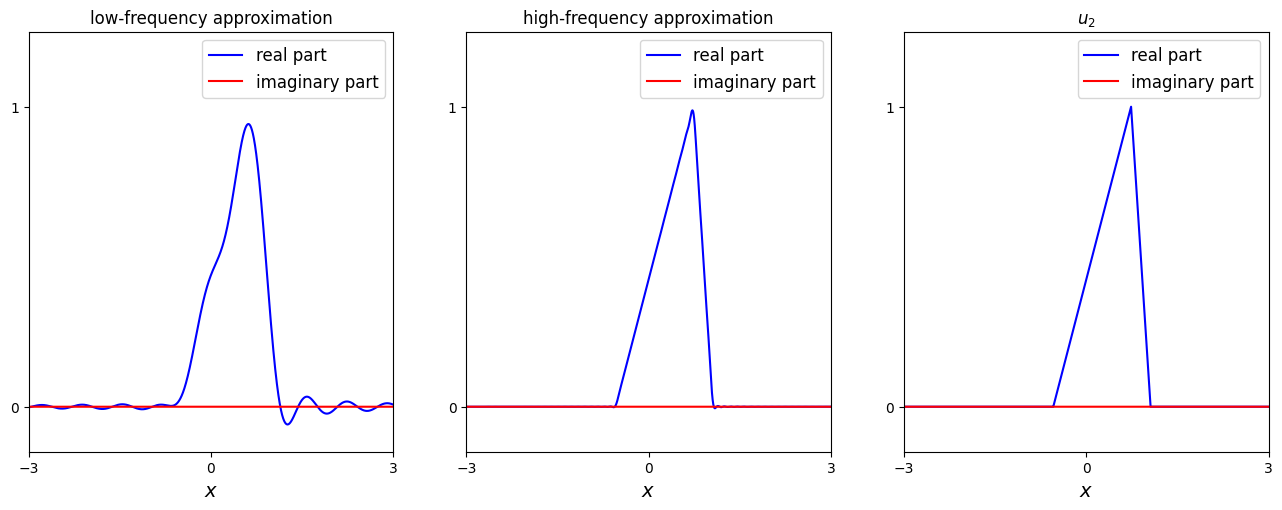

In [16]:
plot_approximations(ua_lo_x, ua_hi_x, u_a(x), title_ex='$u_1$')
plot_approximations(ub_lo_x, ub_hi_x, u_b(x), title_ex='$u_2$')

## Exact multipliers

To each signal corresponds the exact multiplier
$$
  m_{f_k, \alpha} = \frac{D_{\alpha} f_k}{f_k}
$$
which performs exact extrapolation from $\Omega_0$ to $\alpha\Omega_0$.

In [17]:
from adaptiveExtrapolationInFrequency.objects.multiplier import SMultiplier

In [18]:
# create a multiplier for an empty collection
mSa = SMultiplier(ndim = 1, alpha=alpha)
mSb = SMultiplier(ndim = 1, alpha=alpha)
# add function
mSa.append(f_a)
mSb.append(f_b)
# add domain
mSa.domain = DS
mSb.domain = DS
# optimal multipliers
ma = lambda w : mSa.eval_windowed(np.eye(1), w)
mb = lambda w : mSb.eval_windowed(np.eye(1), w)

Plot the exact multipliers in the spatial and frequency domains.

In [19]:
# multipliers
ma_w = ma(w)
mb_w = mb(w)
# filters
ha_x = inverse_fourier_transform_1d(ma, x, mSa.domain.width, M)
hb_x = inverse_fourier_transform_1d(mb, x, mSa.domain.width, M)

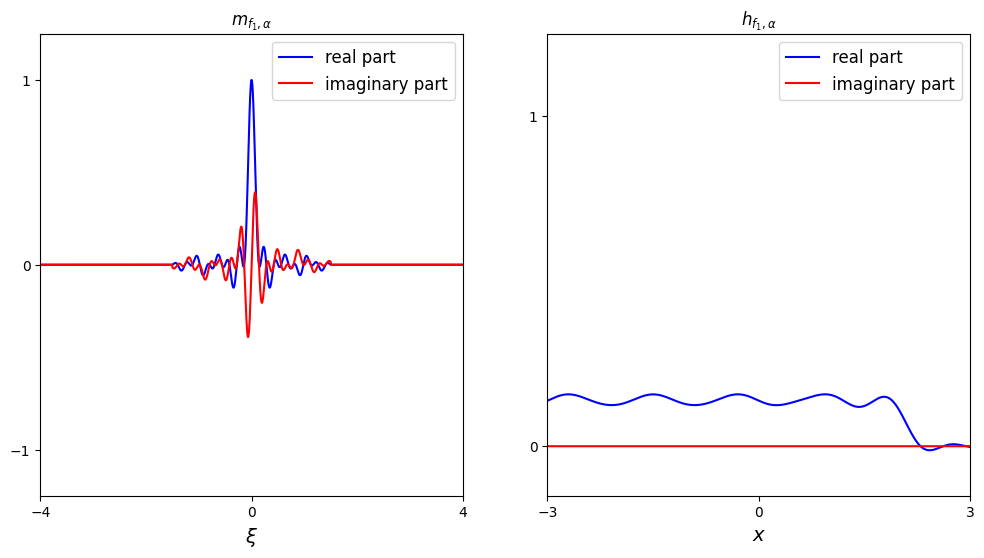

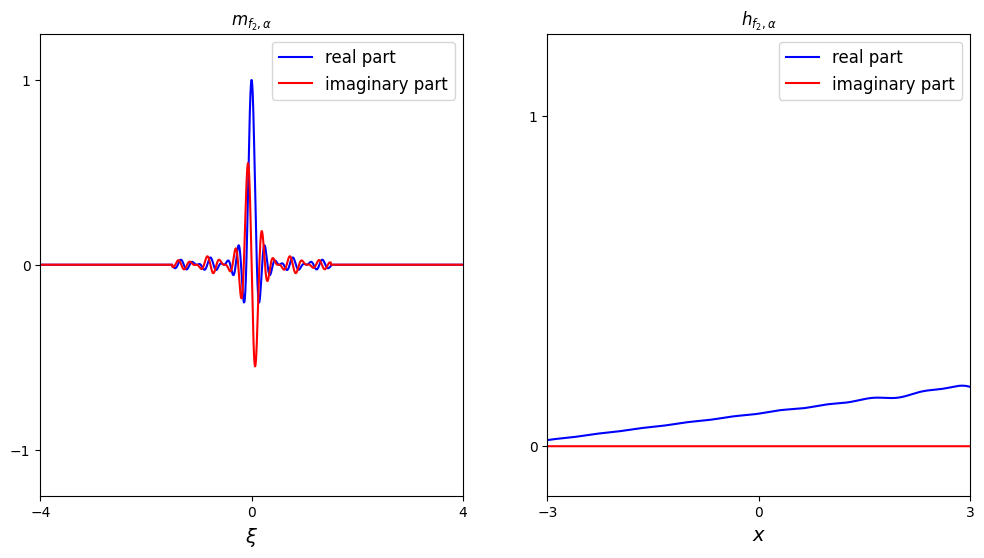

In [20]:
plot_fourier_pair(ma_w, ha_x, title_f='$m_{f_1,\\alpha}$', title_u='$h_{f_1,\\alpha}$')
plot_fourier_pair(mb_w, hb_x, title_f='$m_{f_2,\\alpha}$', title_u='$h_{f_2,\\alpha}$')

### Extrapolation in frequency with exact multipliers

Given a multiplier $m$ on $\Omega$ we can resolve fine-scale details using the approximation
$$
  u(x) \approx \int_{\Omega_0} f(\xi) e^{2\pi i \xi x}\, d\xi + \int_{\alpha\Omega_0 \setminus \Omega_0} m(\alpha^{-1}\xi)f(\alpha^{-1}\xi) e^{2 \pi i \xi x}\, d\xi = \int_{\Omega_0} f(\xi) e^{2\pi i \xi x}\, d\xi + \alpha \int_{\Omega_0 \setminus \alpha^{-1}\Omega_0} m(\xi)f(\xi) e^{2 \pi i \alpha\xi x}\, d\xi
$$
where $u$ and $f$ are a Fourier pair.

In [21]:
def extrapolated_details(m, f):
  return inverse_fourier_transform_1d(lambda w : D_hi.eval_window(w) * (1 - D_lo.eval_window(w)) * m(w/alpha) * f(w/alpha), x, D_hi.width, M)

In [22]:
ua_ex_ext_x = ua_lo_x + extrapolated_details(ma, f_a)
ub_ex_ext_x = ub_lo_x + extrapolated_details(mb, f_b)

When using the exact multipliers we recover the high-frequency approximation.

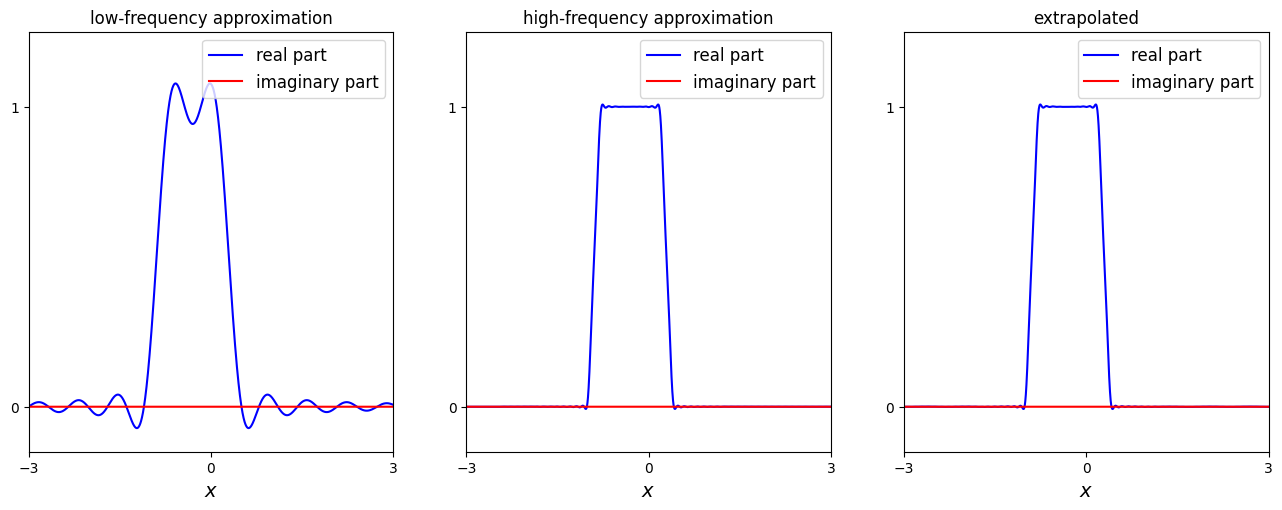

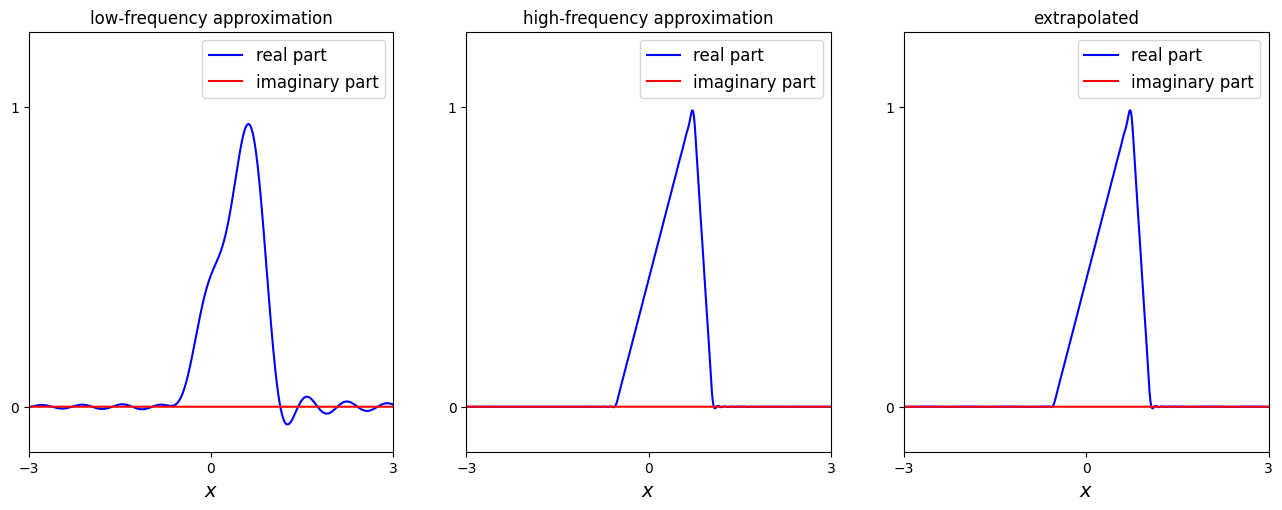

In [23]:
plot_approximations(ua_lo_x, ua_hi_x, ua_ex_ext_x, title_ex='extrapolated')
plot_approximations(ub_lo_x, ub_hi_x, ub_ex_ext_x, title_ex='extrapolated')

## MSE optimal multiplier

The MSE optimal multiplier is
$$
  m_{I} = \frac{f_1^* D_{\alpha} f_1 + f_2^* D_{\alpha} f_2}{|f_1|^2 + |f_2|^2}.
$$

In [24]:
# create a multiplier for an empty collection
mS_mse = SMultiplier(ndim = 1, alpha=alpha)
# add function
mS_mse.append(f_a)
mS_mse.append(f_b)
# add domain
mS_mse.domain = DS 
# MSE optimal multiplier
m_mse = lambda w : mS_mse.eval_windowed(np.eye(2), w)

Plot the MSE optimal multiplier in the spatial and frequency domains.

In [25]:
# multiplier
m_mse_w = m_mse(w)
# filter
h_mse_x = inverse_fourier_transform_1d(m_mse, x, mS_mse.domain.width, M)

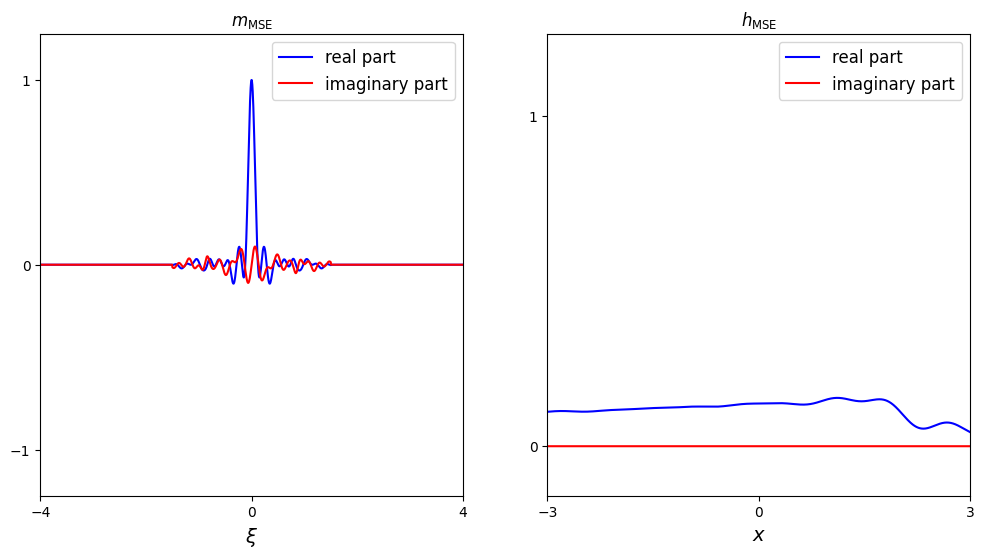

In [26]:
plot_fourier_pair(m_mse_w, h_mse_x, title_f='$m_{\\text{MSE}}$', title_u='$h_{\\text{MSE}}$')

### Extrapolation in frequency using the MSE optimal multiplier

Perform frequency extrapolation for both signals using the MSE optimal multiplier.

In [27]:
ua_mse_ext_x = ua_lo_x + extrapolated_details(m_mse, f_a)
ub_mse_ext_x = ub_lo_x + extrapolated_details(m_mse, f_b)

When using the MSE optimal multiplier we observe noticeable artifacts.

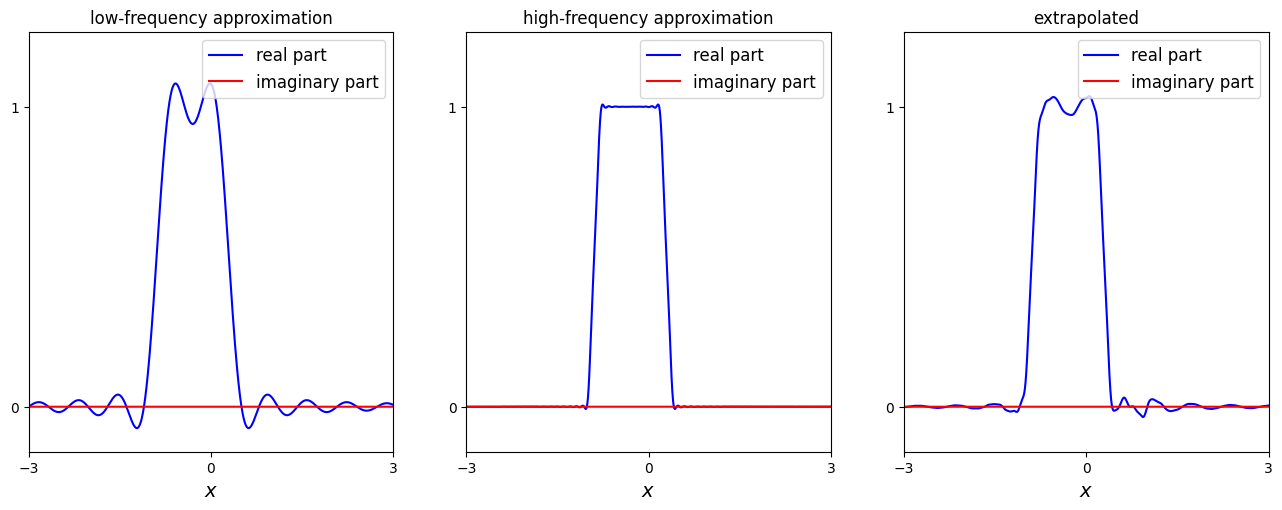

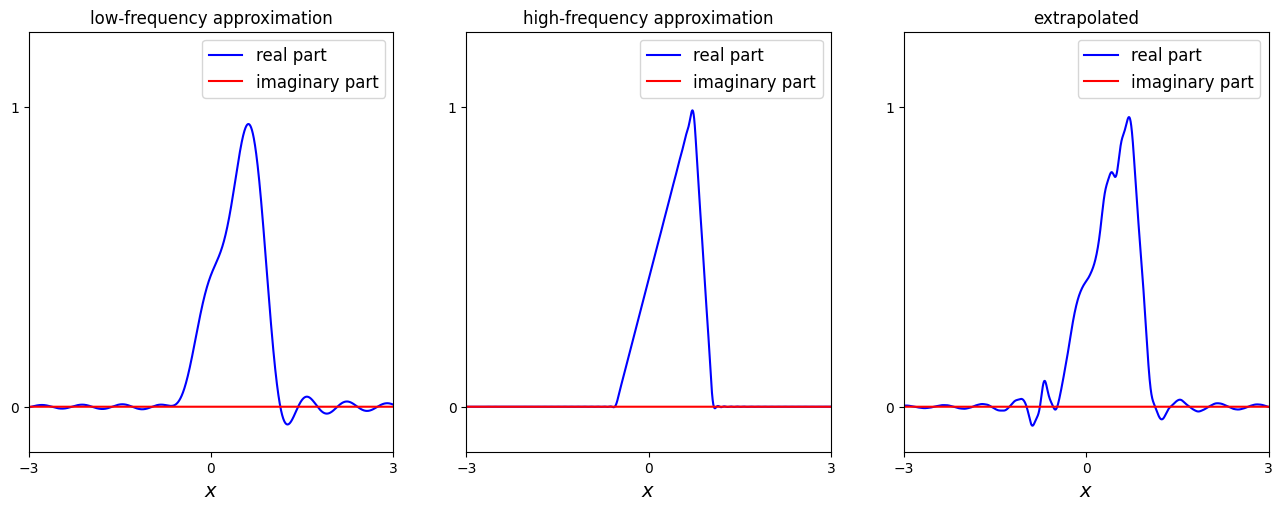

In [28]:
plot_approximations(ua_lo_x, ua_hi_x, ua_mse_ext_x, title_ex='extrapolated')
plot_approximations(ub_lo_x, ub_hi_x, ub_mse_ext_x, title_ex='extrapolated')

## MSE optimal multiplier with centering

A reasonable approach to improve the performance of the MSE optimal multiplier is to *center* the signals first. In this case, we center them using their center of mass
$$
  \mu_k = \left.\int x|u(x)|^2\,dx \middle / \int |u(x)|^2\, dx\right.
$$

In [29]:
ca = np.sum(x * np.abs(u_a(x)) ** 2)/np.sum(np.abs(u_a(x)) ** 2)
cb = np.sum(x * np.abs(u_b(x)) ** 2)/np.sum(np.abs(u_b(x)) ** 2)

print(f'The center of mass of u_a is {ca:+.4f}')
print(f'The center of mass of u_b is {cb:+.4f}')

The center of mass of u_a is -0.3000
The center of mass of u_b is +0.4977


We center both signals.

In [30]:
# centered trapezoid
cu_a = trapezoid(co_a - ca, scale_a, delta_a)
cf_a = trapezoid_fourier(co_a - ca, scale_a, delta_a)

# centered triangle
cu_b = triangle(co_b - cb, scale_b, delta_b)
cf_b = triangle_fourier(co_b - cb, scale_b, delta_b)

# verify
_ca = np.sum(x * np.abs(cu_a(x)) ** 2)/np.sum(np.abs(cu_a(x)) ** 2)
_cb = np.sum(x * np.abs(cu_b(x)) ** 2)/np.sum(np.abs(cu_b(x)) ** 2)

print(f'The center of mass of u_a after centering is {_ca:+.4f}')
print(f'The center of mass of u_b after centering is {_cb:+.4f}')

The center of mass of u_a after centering is -0.0000
The center of mass of u_b after centering is -0.0000


Define the MSE optimal multiplier using the centered signals.

In [31]:
# create a multiplier for an empty collection
cmS_mse = SMultiplier(ndim = 1, alpha=alpha)
# add function
cmS_mse.append(cf_a)
cmS_mse.append(cf_b)
# add domain
cmS_mse.domain = DS 
# MSE optimal multiplier
cm_mse = lambda w : cmS_mse.eval_windowed(np.eye(2), w)

Plot the MSE optimal multiplier in the spatial and frequency domains.

In [32]:
# multiplier
cm_mse_w = cm_mse(w)
# filter
ch_mse_x = inverse_fourier_transform_1d(cm_mse, x, cmS_mse.domain.width, M)

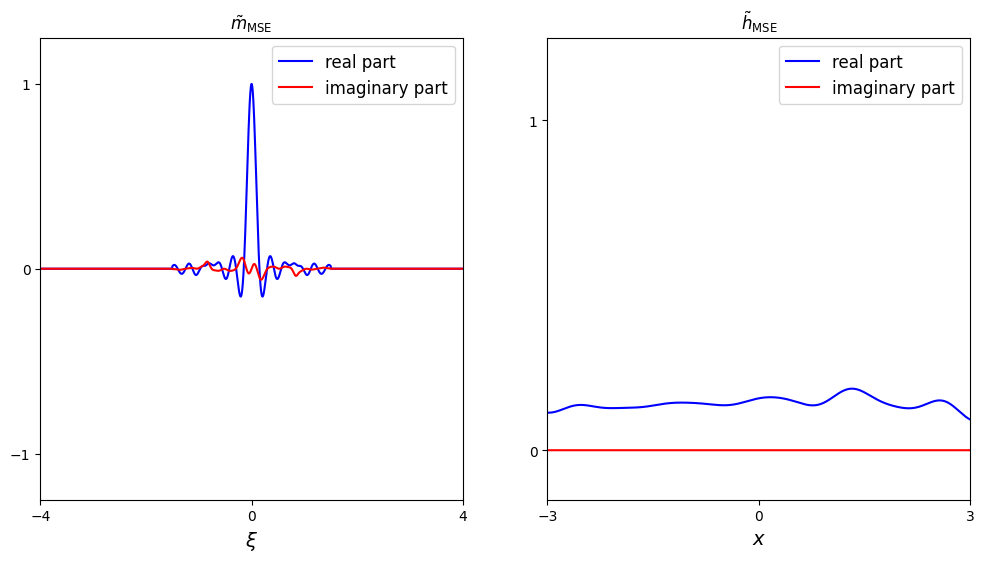

In [33]:
plot_fourier_pair(cm_mse_w, ch_mse_x, title_f='$\\tilde{m}_{\\text{MSE}}$', title_u='$\\tilde{h}_{\\text{MSE}}$')

### Extrapolation in frequency using the MSE optimal multiplier with centering

Perform frequency extrapolation for both signals using the MSE optimal multiplier. Since this multiplier is defined in terms of the **centered** signals we need to both extrapolate in frequency and translate to the original location.

In [34]:
# define optimal multiplier with translation
cm_mse_tr = lambda w, xo : np.exp(2 * np.pi * 1j * xo * w) * (np.exp(2 * np.pi * 1j * (alpha - 1.0) * ca * w) *np.conj(f_a(w)) * f_a(alpha * w) + np.exp(2 * np.pi * 1j * (alpha - 1.0) * cb * w) * np.conj(f_b(w)) * f_b(alpha * w)) / (1E-32 + np.abs(f_a(w)) ** 2 + np.abs(f_b(w)) ** 2)

In [35]:
# # low-frequency approximation
# cua_lo_x = inverse_fourier_transform_1d(lambda w : D_lo.eval_window(w) * cf_a(w), x, xi_max, 4096)
# cub_lo_x = inverse_fourier_transform_1d(lambda w : D_lo.eval_window(w) * cf_b(w), x, xi_max, 4096)
# # high-frequency approximation
# cua_hi_x = inverse_fourier_transform_1d(lambda w : D_hi.eval_window(w) * cf_a(w), x, alpha * xi_max, 1096)
# cub_hi_x = inverse_fourier_transform_1d(lambda w : D_hi.eval_window(w) * cf_b(w), x, alpha * xi_max, 1096)

In [36]:
# cua_mse_ext_x = cua_lo_x + extrapolated_details(cm_mse, cf_a)
# cub_mse_ext_x = cub_lo_x + extrapolated_details(cm_mse, cf_b)

In [37]:
cua_mse_ext_x = ua_lo_x + extrapolated_details(lambda w : cm_mse_tr(w, -(alpha - 1.0) * ca), f_a)
cub_mse_ext_x = ub_lo_x + extrapolated_details(lambda w : cm_mse_tr(w, -(alpha - 1.0) * cb), f_b)

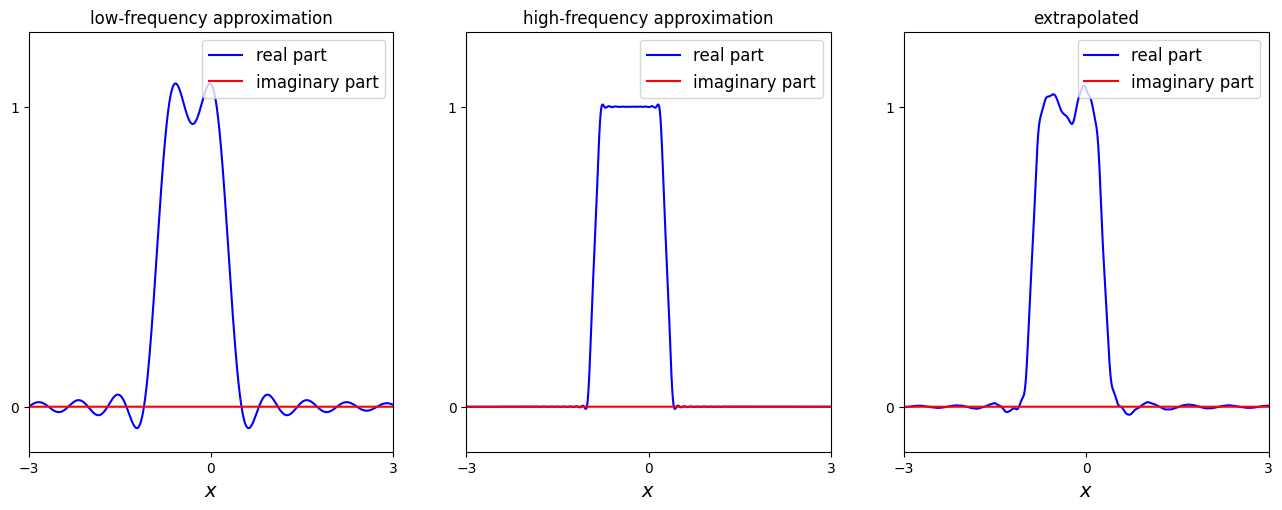

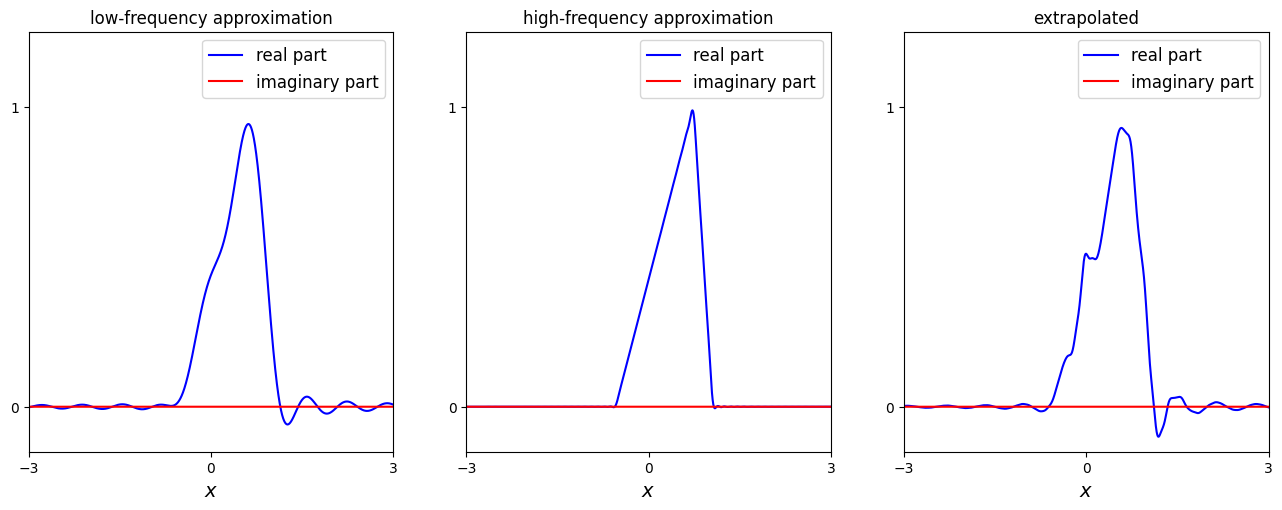

In [38]:
plot_approximations(ua_lo_x, ua_hi_x, cua_mse_ext_x, title_ex='extrapolated')
plot_approximations(ub_lo_x, ub_hi_x, cub_mse_ext_x, title_ex='extrapolated')

## Translation-invariant MSE optimal multiplier

We find the optimal translation. The optimal translation corresponds to the global minimizer of the function $g$ with Fourier transform
$$
  \widehat{g}(\xi) = - \chi_{\Omega}\frac{|f_1|^2 |f_2|^2}{|f_1|^2 + |f_2|^2} m_{f_1, \alpha}^* m_{f_2,\alpha}.
$$

In [39]:
# function handle
wh_go = lambda w : - (np.conj(ma(w)) * mb(w)) * (np.abs(f_a(w)) * np.abs(f_b(w))) ** 2 / (1E-32 + np.abs(f_a(w)) ** 2 + np.abs(f_b(w)) ** 2)
wh_g = lambda w : D_hi.eval_window(w) * (1 - D_lo.eval_window(w)) * wh_go(w/alpha)
# evaluated
wh_g_w = wh_g(w)
# inverse
g_x = inverse_fourier_transform_1d(wh_g, x, D_hi.width, M)
# objective
z = np.linspace(-3, +3, 8192, endpoint=True)
g_z = inverse_fourier_transform_1d(wh_g, z, D_hi.width, M)

# minimum z
z_opt = z[np.argmin(g_z.real)]
g_opt = g_z.real.min()

print(f'The minimum value is {g_opt.real:.3f} and it is attained at z = {z_opt:.3f}')

The minimum value is -0.002 and it is attained at z = 1.920


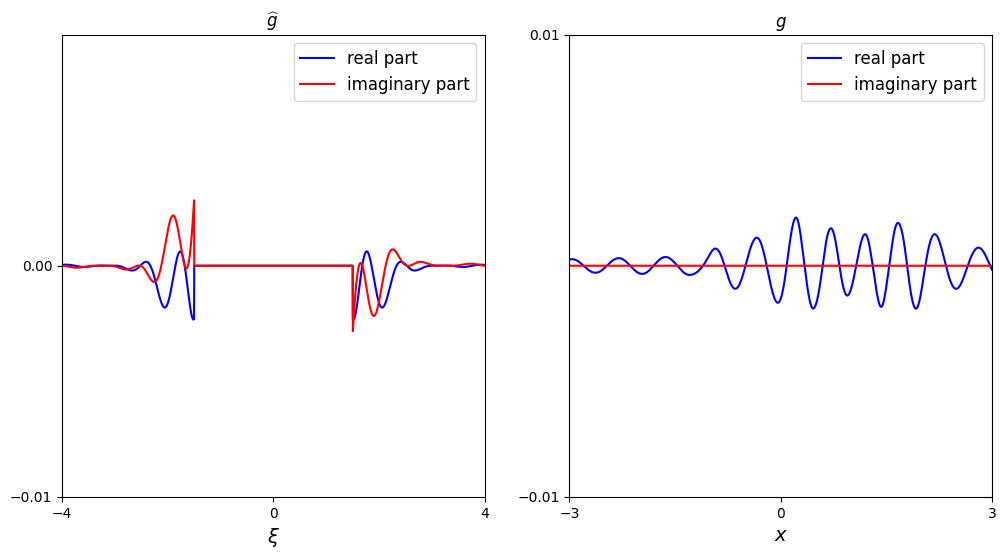

In [40]:
plot_fourier_pair(wh_g_w, g_x, title_f='$\\widehat{g}$', title_u='$g$', lim_f=[ -0.01, 0.01 ], lim_u=[ -0.01, 0.01 ], ticks_f=[ -0.01, 0.00 ], ticks_u=[ -0.01, 0.01 ])

In [41]:
# figures for paper ------------------------------------------------------------------------------------------
# --- spatial domain
plt.figure(figsize=(8, 8))
plt.plot(z, g_z.real, color='b', label='Re($g$)', linewidth=3)
plt.plot(z, g_z.imag, color='r', label='Im($g$)', linewidth=3, zorder=-1)
plt.scatter(z_opt, g_opt, s=32, marker='o', color='r', zorder=2)
plt.plot([ z_opt, z_opt ], [ 0.0, g_opt ], color='r', linewidth=2)
plt.xlim([ z.min(), z.max() ])
plt.ylim([ -5E-3, +5E-3 ])
plt.xticks([ z.min(), 0, z.max() ], fontsize=22)
plt.yticks([])
plt.xlabel('$z$', fontsize=24)
plt.legend(fontsize=24, loc='upper right')

savefig('OBJECTIVE_Z_SPACE')

plt.close()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


We must scale by a factor $\alpha$.

In [42]:
x_opt = alpha * z_opt

print(f'The optimal separation is Delta x = {x_opt:.3f}')

The optimal separation is Delta x = 11.517


### Extrapolation in frequency using optimal centerings

In [43]:
# define optimal multiplier
m_opt = lambda w, xo : np.exp(2 * np.pi * 1j * xo * w) * (np.conj(f_a(w)) * f_a(alpha * w) + np.exp(2 * np.pi * 1j * x_opt * w) * np.conj(f_b(w)) * f_b(alpha * w)) / (1E-32 + np.abs(f_a(w)) ** 2 + np.abs(f_b(w)) ** 2)

In [44]:
ocua_ext_x = ua_lo_x + extrapolated_details(lambda w : m_opt(w, 0.0), f_a)
ocub_ext_x = ub_lo_x + extrapolated_details(lambda w : m_opt(w, -x_opt), f_b)

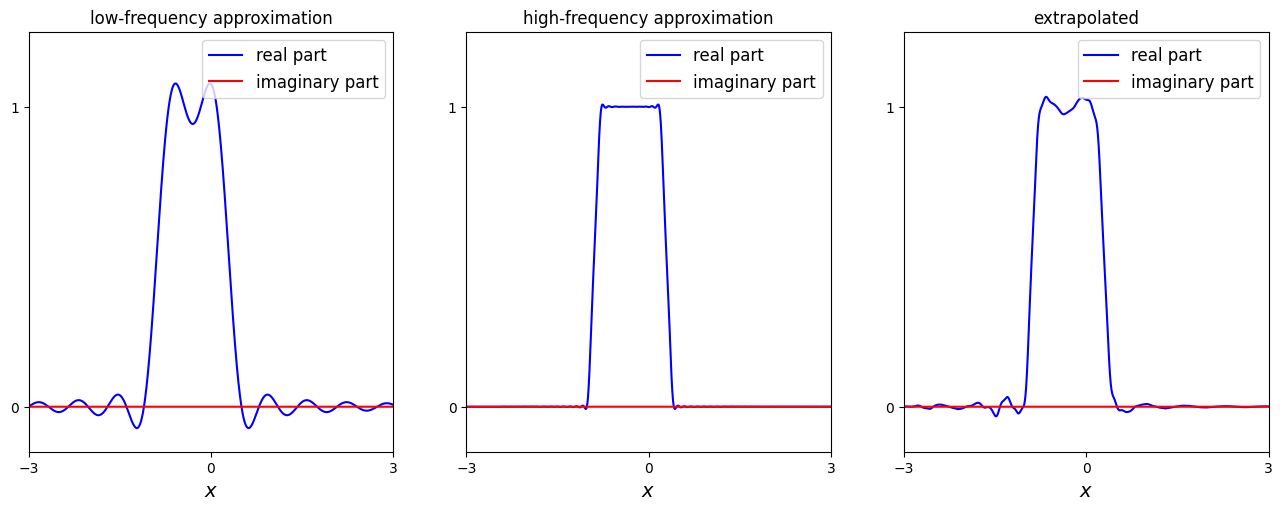

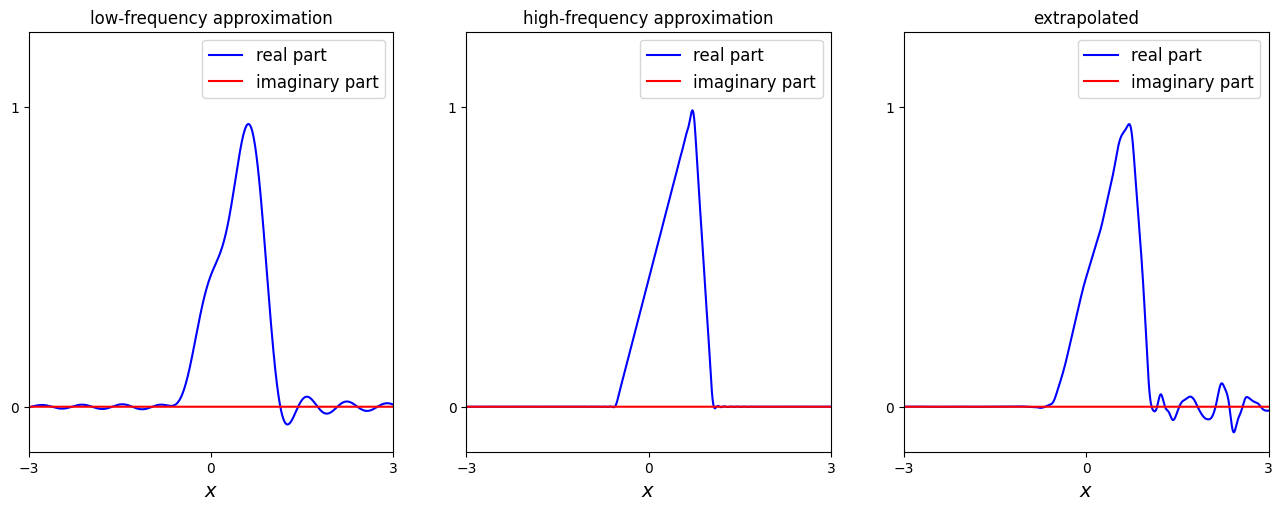

In [45]:
plot_approximations(ua_lo_x, ua_hi_x, ocua_ext_x, title_ex='extrapolated')
plot_approximations(ub_lo_x, ub_hi_x, ocub_ext_x, title_ex='extrapolated')

## Comparison

Compare the performance of each method.

In [46]:
# step
dx = x[1] - x[0]

In [47]:
# summary
print('Signal A')
print('MSE-OM')
print(f' - MSE   : {dx * np.sum((ua_mse_ext_x - ua_hi_x).real ** 2):.3E}')
print(f' - SNR   : {10 * np.log10(np.sum(ua_hi_x.real ** 2) / np.sum((ua_mse_ext_x - ua_hi_x).real ** 2)):.3f}')
print(f' - PSNR  : {10 * np.log10((ua_hi_x.real ** 2).max() / (dx * np.sum((ua_mse_ext_x - ua_hi_x).real ** 2))):.3f}')

print('MSE-OM+C')
print(f' - MSE   : {dx * np.sum((cua_mse_ext_x - ua_hi_x).real ** 2):.3E}')
print(f' - SNR   : {10 * np.log10(np.sum(ua_hi_x.real ** 2) / np.sum((cua_mse_ext_x - ua_hi_x).real ** 2)):.3f}')
print(f' - PSNR  : {10 * np.log10((ua_hi_x.real ** 2).max() / (dx * np.sum((cua_mse_ext_x - ua_hi_x).real ** 2))):.3f}')

print('TI-MSE-OM')
print(f' - MSE   : {dx * np.sum((ocua_ext_x - ua_hi_x).real ** 2):.3E}')
print(f' - SNR   : {10 * np.log10(np.sum(ua_hi_x.real ** 2) / np.sum((ocua_ext_x - ua_hi_x).real ** 2)):.3f}')
print(f' - PSNR  : {10 * np.log10((ua_hi_x.real ** 2).max() / (dx * np.sum((ocua_ext_x - ua_hi_x).real ** 2))):.3f}')

Signal A
MSE-OM
 - MSE   : 1.570E-03
 - SNR   : 28.534
 - PSNR  : 28.106
MSE-OM+C
 - MSE   : 3.330E-03
 - SNR   : 25.268
 - PSNR  : 24.840
TI-MSE-OM
 - MSE   : 1.323E-03
 - SNR   : 29.275
 - PSNR  : 28.847


In [48]:
print('Signal B')
print('MSE-OM')
print(f' - MSE   : {dx * np.sum((ub_mse_ext_x - ub_hi_x).real ** 2):.3E}')
print(f' - SNR   : {10 * np.log10(np.sum(ub_hi_x.real ** 2) / np.sum((ub_mse_ext_x - ub_hi_x).real ** 2)):.3f}')
print(f' - PSNR  : {10 * np.log10((ub_hi_x.real ** 2).max() / (dx * np.sum((ub_mse_ext_x - ub_hi_x).real ** 2))):.3f}')

print('MSE-OM+C')
print(f' - MSE   : {dx * np.sum((cub_mse_ext_x - ub_hi_x).real ** 2):.3E}')
print(f' - SNR   : {10 * np.log10(np.sum(ub_hi_x.real ** 2) / np.sum((cub_mse_ext_x - ub_hi_x).real ** 2)):.3f}')
print(f' - PSNR  : {10 * np.log10((ub_hi_x.real ** 2).max() / (dx * np.sum((cub_mse_ext_x - ub_hi_x).real ** 2))):.3f}')

print('TI-MSE-OM')
print(f' - MSE   : {dx * np.sum((ocub_ext_x - ub_hi_x).real ** 2):.3E}')
print(f' - SNR   : {10 * np.log10(np.sum(ub_hi_x.real ** 2) / np.sum((ocub_ext_x - ub_hi_x).real ** 2)):.3f}')
print(f' - PSNR  : {10 * np.log10((ub_hi_x.real ** 2).max() / (dx * np.sum((ocub_ext_x - ub_hi_x).real ** 2))):.3f}')


Signal B
MSE-OM
 - MSE   : 3.185E-03
 - SNR   : 22.239
 - PSNR  : 24.863
MSE-OM+C
 - MSE   : 6.949E-03
 - SNR   : 18.850
 - PSNR  : 21.475
TI-MSE-OM
 - MSE   : 2.648E-03
 - SNR   : 23.041
 - PSNR  : 25.666


In [49]:
def plot_compare_approximations(u_lo_x, u_hi_x, u_ext_x, cu_ext_x, ocu_ext_x, title_ext, title_cext, title_ocext,
                                title_lo='low-frequency approximation', title_hi='high-frequency approximation'):
  plt.figure(figsize=(26, 12))
  plt.subplot(2, 5, 1)
  plt.plot(x, u_lo_x.real, color='b', label=label_real)
  plt.plot(x, u_lo_x.imag, color='r', label=label_imag)
  plt.xlim([ x.min(), x.max() ])
  plt.ylim([ -0.15, +1.25 ])
  plt.xticks([ x.min(), 0.0, x.max() ])
  plt.yticks([ 0.0, 1.0 ])
  plt.xlabel('$x$', fontsize=14)
  plt.legend(fontsize=12, loc='upper right')
  plt.title(title_lo)
  plt.subplot(2, 5, 2)
  plt.plot(x, u_hi_x.real, color='b', label=label_real)
  plt.plot(x, u_hi_x.imag, color='r', label=label_imag)
  plt.xlim([ x.min(), x.max() ])
  plt.ylim([ -0.15, +1.25 ])
  plt.xticks([ x.min(), 0.0, x.max() ])
  plt.yticks([ 0.0, 1.0 ])
  plt.xlabel('$x$', fontsize=14)
  plt.legend(fontsize=12, loc='upper right')
  plt.title(title_hi)
  plt.subplot(2, 5, 3)
  plt.plot(x, u_ext_x.real, color='b', label=label_real)
  plt.plot(x, u_ext_x.imag, color='r', label=label_imag)
  plt.xlim([ x.min(), x.max() ])
  plt.ylim([ -0.15, +1.25 ])
  plt.xticks([ x.min(), 0.0, x.max() ])
  plt.yticks([ 0.0, 1.0 ])
  plt.xlabel('$x$', fontsize=14)
  plt.legend(fontsize=12, loc='upper right')
  plt.title(title_ext)
  plt.subplot(2, 5, 4)
  plt.plot(x, cu_ext_x.real, color='b', label=label_real)
  plt.plot(x, cu_ext_x.imag, color='r', label=label_imag)
  plt.xlim([ x.min(), x.max() ])
  plt.ylim([ -0.15, +1.25 ])
  plt.xticks([ x.min(), 0.0, x.max() ])
  plt.yticks([ 0.0, 1.0 ])
  plt.xlabel('$x$', fontsize=14)
  plt.legend(fontsize=12, loc='upper right')
  plt.title(title_cext)
  plt.subplot(2, 5, 5)
  plt.plot(x, ocu_ext_x.real, color='b', label=label_real)
  plt.plot(x, ocu_ext_x.imag, color='r', label=label_imag)
  plt.xlim([ x.min(), x.max() ])
  plt.ylim([ -0.15, +1.25 ])
  plt.xticks([ x.min(), 0.0, x.max() ])
  plt.yticks([ 0.0, 1.0 ])
  plt.xlabel('$x$', fontsize=14)
  plt.legend(fontsize=12, loc='upper right')
  plt.title(title_ocext)
  plt.show()

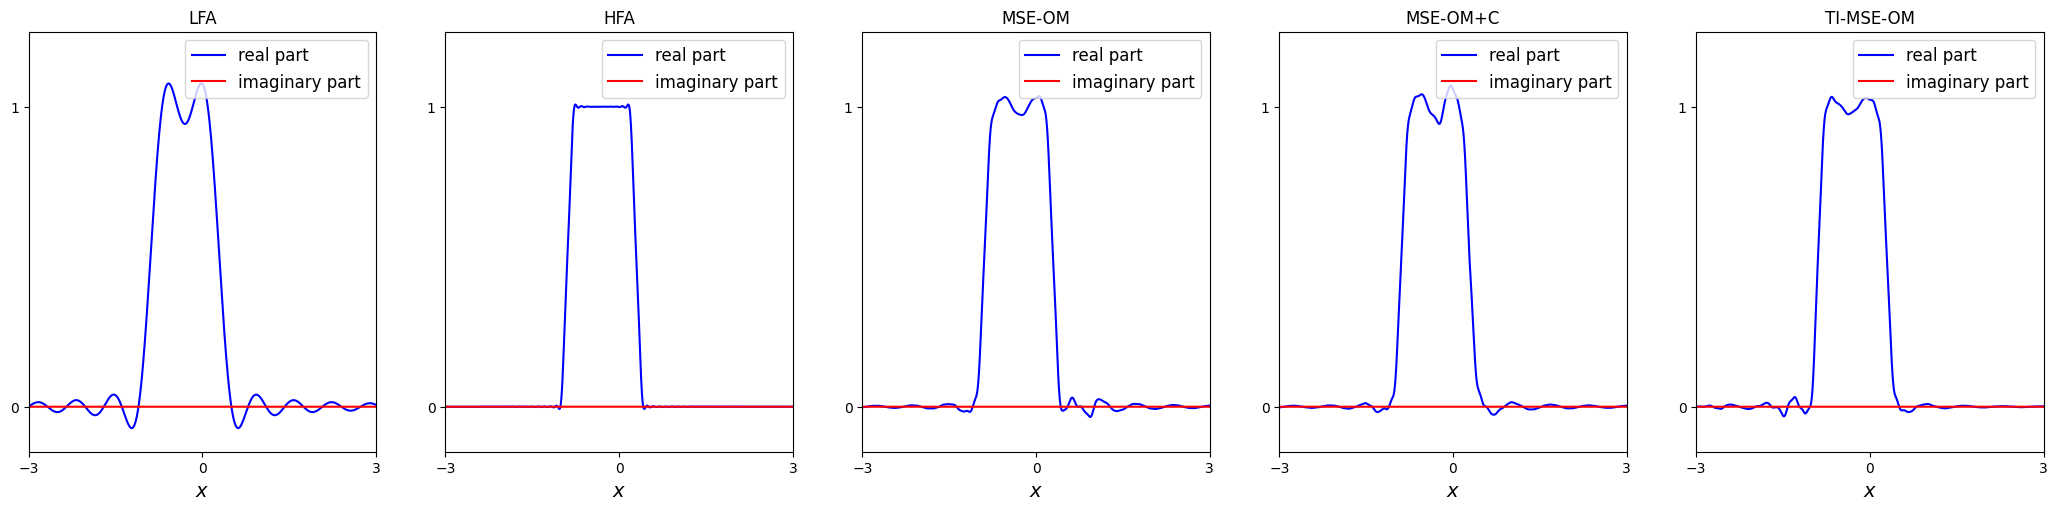

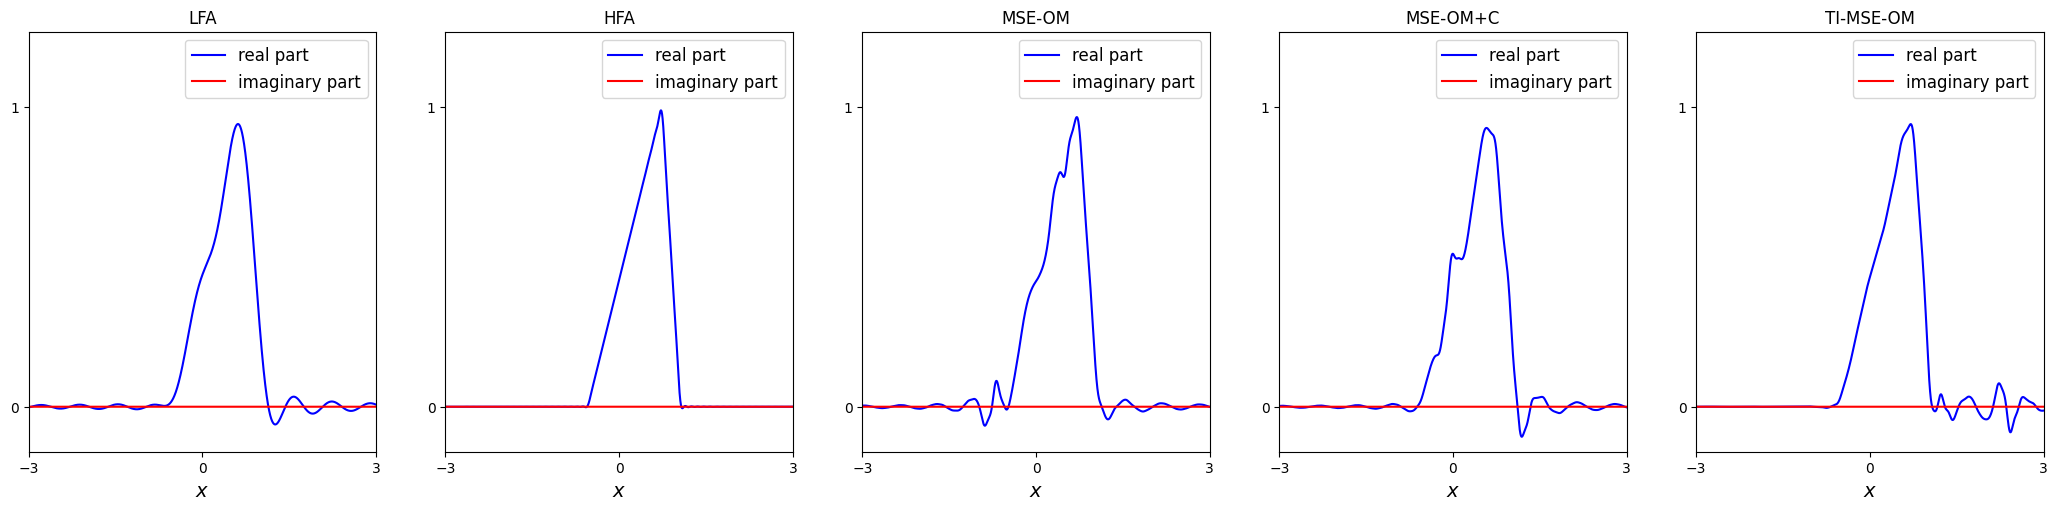

In [50]:
plot_compare_approximations(ua_lo_x, ua_hi_x, ua_mse_ext_x, cua_mse_ext_x, ocua_ext_x, title_lo='LFA', title_hi='HFA', title_ext='MSE-OM', title_cext='MSE-OM+C', title_ocext='TI-MSE-OM')
plot_compare_approximations(ub_lo_x, ub_hi_x, ub_mse_ext_x, cub_mse_ext_x, ocub_ext_x, title_lo='LFA', title_hi='HFA', title_ext='MSE-OM', title_cext='MSE-OM+C', title_ocext='TI-MSE-OM')

In [51]:
# figures for paper ------------------------------------------------------------------------------------------
def plot_extrapolation(u_hi, u_ext, label, fname, legside):
  plt.figure(figsize=(8, 8))
  plt.axhline(0, x.min(), x.max(), color='k', zorder=-1, linewidth=1)
  plt.plot(x, u_ext.real, color='b', linewidth=3, label=label)
  plt.plot(x, u_hi.real, color='r', linewidth=3, linestyle='--', alpha=0.75, label='HFA')
  plt.xlim([ x.min(), x.max() ])
  plt.ylim([ -0.05, +1.35 ])
  plt.xticks([ x.min(), 0, x.max() ], fontsize=22)
  plt.yticks([ 0.0, +1.0 ], fontsize=22)
  plt.xlabel('$x$', fontsize=24)
  plt.legend(fontsize=24, loc='upper ' + legside)

  savefig('SIGNAL_EXT_' + fname)

  plt.close()

# signal a
plot_extrapolation(ua_hi_x, ua_mse_ext_x, 'MSE-OM', 'A_NC', 'right')
plot_extrapolation(ua_hi_x, cua_mse_ext_x, 'MSE-OM+C', 'A_C', 'right')
plot_extrapolation(ua_hi_x, ocua_ext_x, 'TI-MSE-OM', 'A_OC', 'right')
# signal b
plot_extrapolation(ub_hi_x, ub_mse_ext_x, 'MSE-OM', 'B_NC', 'left')
plot_extrapolation(ub_hi_x, cub_mse_ext_x, 'MSE-OM+C', 'B_C', 'left')
plot_extrapolation(ub_hi_x, ocub_ext_x, 'TI-MSE-OM', 'B_OC', 'left')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
